In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from pathlib import Path
import seaborn as sns
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('display.max_colwidth', 150)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
raw_data_dir = Path("../data/raw")
fake_path = raw_data_dir / "Fake.csv"
true_path = raw_data_dir / "True.csv"

df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

df_fake['label'] = 0
df_true['label'] = 1

print(f"Fake news samples: {len(df_fake)}, Real news samples: {len(df_true)}")

Fake news samples: 23481, Real news samples: 21417


In [3]:
df_all = pd.concat([df_fake, df_true], ignore_index=True)
df_all = shuffle(df_all, random_state=42).reset_index(drop=True)

df_all = df_all[['title', 'text', 'subject', 'date', 'label']]

df_all.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution,"21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films suc...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Security Council,"WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, reve...",politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shipping restrictions,"(Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal government to waive the Jones Act, which would lift re...",politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Leaked Israeli Intelligence To Russia (VIDEO),"On Monday, Donald Trump once again embarrassed himself and his country by accidentally revealing the source of the extremely classified informatio...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a golf resort,"GLASGOW, Scotland (Reuters) - Most U.S. presidential candidates go abroad to sharpen their foreign policy credentials. Donald Trump arrives in Sco...",politicsNews,"June 24, 2016",1


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ""
    
    text = text.lower() 
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  
    tokens = nltk.word_tokenize(text) 
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    
    return " ".join(tokens)

In [5]:
df_all['combined_text'] = df_all['title'].fillna('') + ' ' + df_all['text'].fillna('')
df_all['cleaned_text'] = df_all['combined_text'].apply(clean_text)

df_all[['label', 'cleaned_text']].sample(5)

,label,cleaned_text
22569,1,clinton hit rival immigration california campaign swing los angeles reuters hillary clinton fought two front california saturday sought wrap battl...
34628,0,left anti defamation league medium used fake information publish huge lie high school killer tie white nationalist immediately police identified s...
30649,1,tillerson call counterpart mexico canada state department official washington reuters secretary state rex tillerson called counterpart mexico cana...
36281,0,trump hater george ramos promotes movie showing illegal alien shot border drunk vigilante…blames trump video mexico beneficiary open border decade...
37237,0,twitter destroyed trump racist comment victory speech video medium hyped fact donald trump used teleprompter speech tuesday night winning final sl...


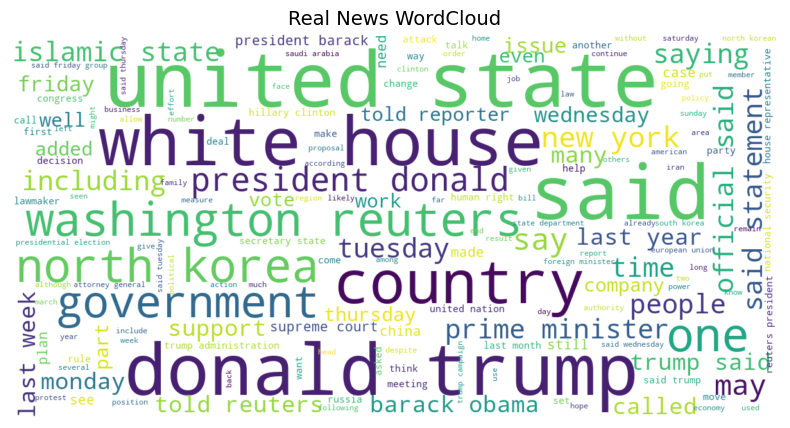

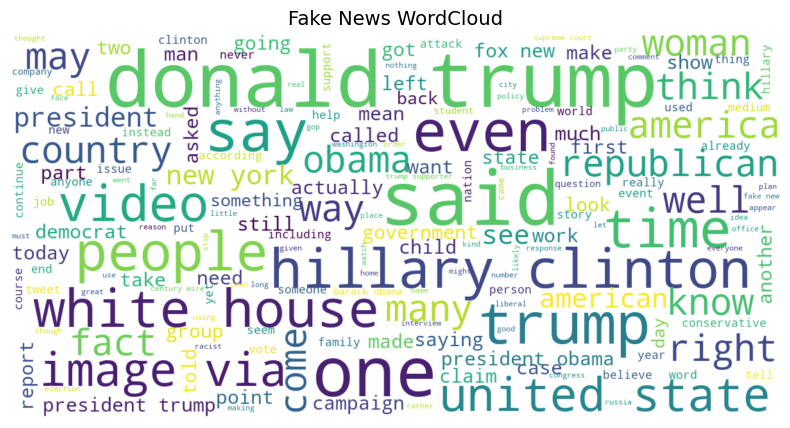

In [6]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42
    ).generate(' '.join(data))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

show_wordcloud(df_all[df_all['label'] == 1]['cleaned_text'], 'Real News WordCloud')
show_wordcloud(df_all[df_all['label'] == 0]['cleaned_text'], 'Fake News WordCloud')

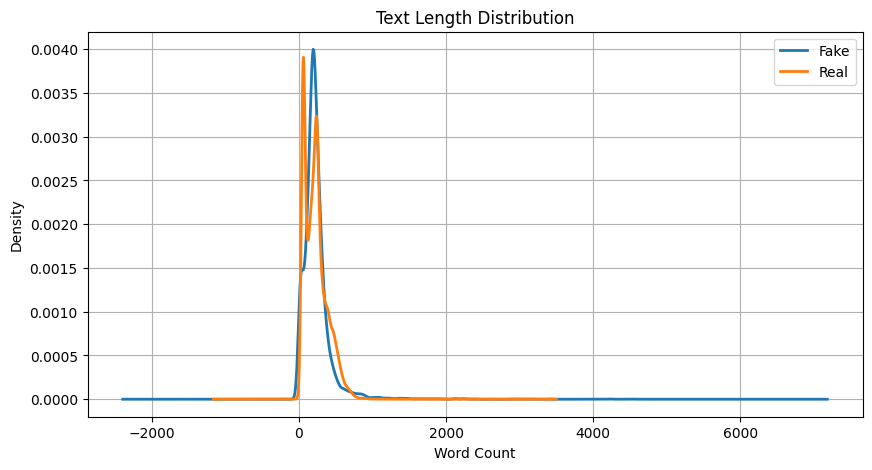

In [7]:
df_all['text_length'] = df_all['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
df_all[df_all['label'] == 0]['text_length'].plot(kind='kde', label='Fake', linewidth=2)
df_all[df_all['label'] == 1]['text_length'].plot(kind='kde', label='Real', linewidth=2)
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

output_path = processed_dir / "cleaned.csv"
df_all[['cleaned_text', 'label']].to_csv(output_path, index=False)

print(f"✅ Cleaned data saved to: {output_path.resolve()}")

✅ Cleaned data saved to: D:\Machine Learning Project\fake-news-detection\data\processed\cleaned.csv


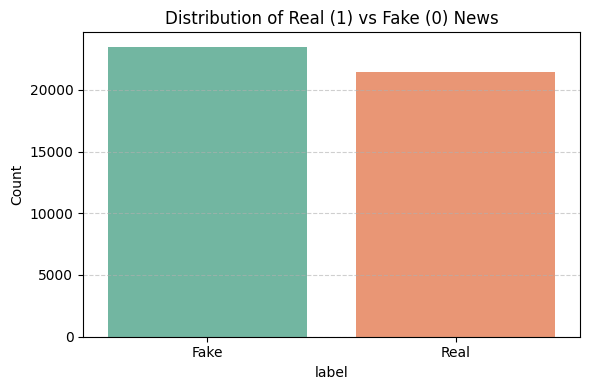

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_all, x='label', hue='label', palette='Set2', legend=False)
plt.title('Distribution of Real (1) vs Fake (0) News')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

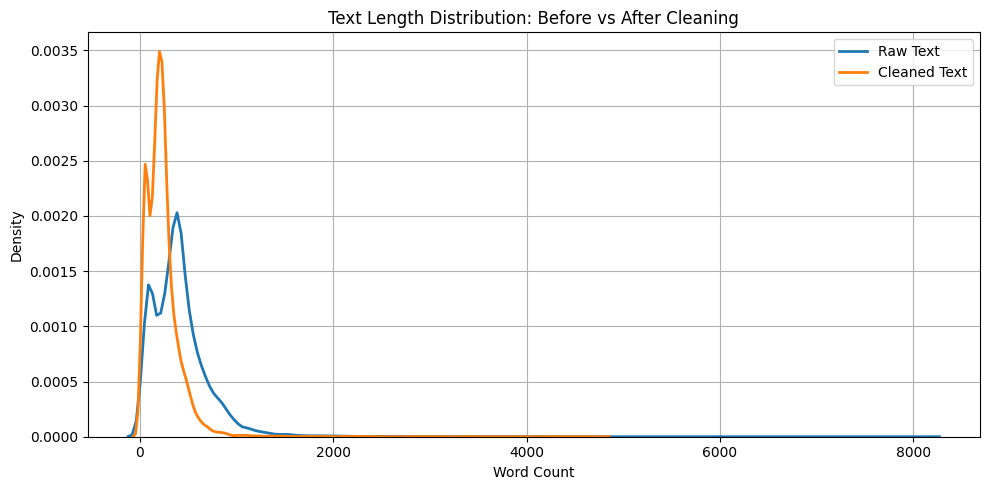

In [13]:
df_all['raw_length'] = df_all['combined_text'].apply(lambda x: len(str(x).split()))
df_all['cleaned_length'] = df_all['cleaned_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.kdeplot(df_all['raw_length'], label='Raw Text', linewidth=2)
sns.kdeplot(df_all['cleaned_length'], label='Cleaned Text', linewidth=2)
plt.title('Text Length Distribution: Before vs After Cleaning')
plt.xlabel('Word Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

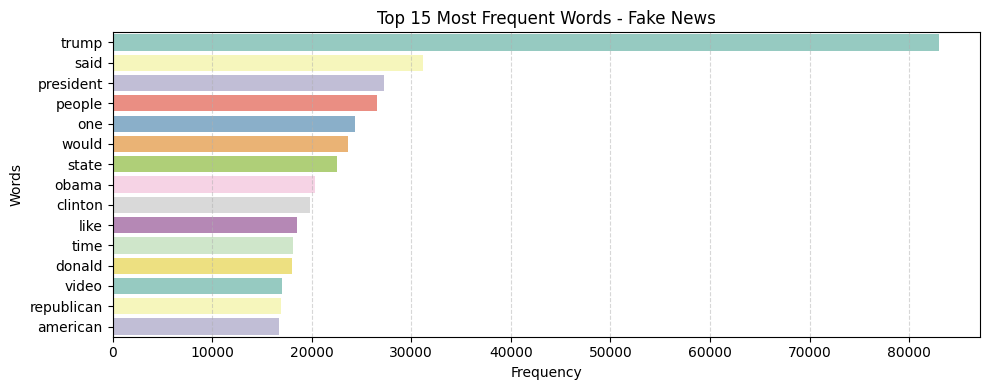

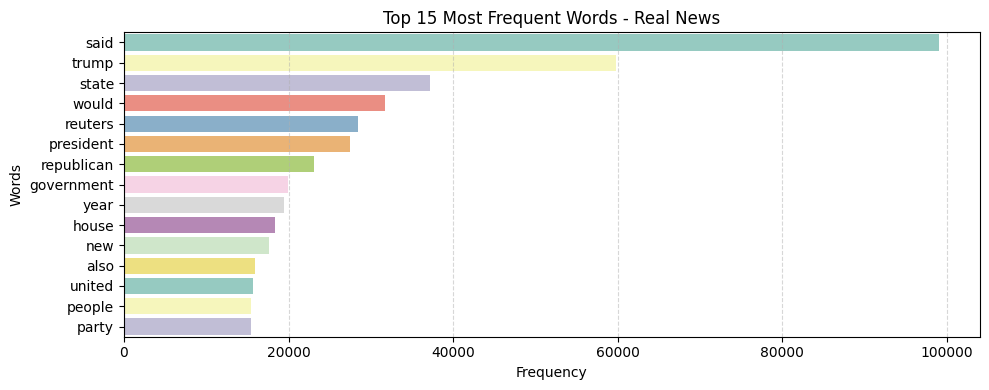

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_words(label: int, n: int = 15):
    subset = df_all[df_all['label'] == label].dropna(subset=['cleaned_text'])

    if subset.empty:
        print(f"⚠️ No data found for label: {label}")
        return

    all_words = ' '.join(subset['cleaned_text']).split()
    if not all_words:
        print(f"⚠️ No words found for label: {label}")
        return

    freq_dist = Counter(all_words).most_common(n)
    df_words = pd.DataFrame(freq_dist, columns=["word", "count"])

    plt.figure(figsize=(10, 4))
    sns.barplot(data=df_words, x="count", y="word", hue="word", dodge=False, palette="Set3", legend=False)
    plt.title(f"Top {n} Most Frequent Words - {'Real' if label == 1 else 'Fake'} News")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_top_words(0)
plot_top_words(1)
